# Tensorflow Basic
### 목표
1. Dataset 이해
2. Estimator 이해
    - 사전 제작된 Estimator
    - Custom Estimator

## Workflow
1. EDA
2. Dataset을 통한 입력함수 생성
3. feature columns 정의
4. Estimator 이용


### 1. EDA

데이터: Iris(붓꽃) data
Iris를 구성하는 꽃받침과 꽃잎의 크기에 따라서 Iris를 세 가지의 다른 종으로 분류되어 있는 데이터.

1개의 데이터 행은 다음과 같이 구성되어 있음
- 꽃받침 길이
- 꽃받침 넓이
- 꽃잎 길이
- 꽃잎 너비
- 종



In [1]:
import tensorflow as tf
import pandas as pd

In [10]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [11]:
train.head()

SepalLength  SepalWidth  PetalLength  PetalWidth  Species
0          6.4         2.8          5.6         2.2        2
1          5.0         2.3          3.3         1.0        1
2          4.9         2.5          4.5         1.7        2
3          4.9         3.1          1.5         0.1        0
4          5.7         3.8          1.7         0.3        0

꽃의 종에 따라서 꽃잎과 꽃받침의 길이에 차이가 있음을 확인

In [15]:
val_by_spec = train.groupby("Species").mean()

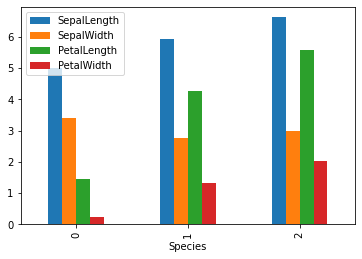

In [21]:
val_by_spec.plot(kind='bar')

데이터를 Input과 Output으로 분리

In [22]:
train_y = train.pop('Species')
test_y = test.pop('Species')

## 입력함수
#### tf.data.Dataset
입력함수는 `tf.data.Dataset`를 이용하여 만들 수 있음. `tf.data.Dataset`은 다양한 데이터를 다룰 수 있으며, 배치기능 등을 포함하고 있음.

`tf.data.Dataset`을 통해 모델 학습에서 입력 파이프라인을 빌드할 수 있음

In [35]:
def input_fn(features, labels, training=True, batch_size=256):
    # Pandas 타입의 데이터를 tf.data.Dataset 타입으로 변환
    # features의 경우 feature_column을 이용하여 dictionary를 통해 상세화 할 수 있음
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    if training:
        dataset = dataset.shuffle(1000).repeat()
        
    # 배치크기에 맞는 데이터를 반환한다
    return dataset.batch(batch_size)


In [36]:
input_fn(train.head(), train_y.head())

<BatchDataset shapes: ({SepalLength: (None,), SepalWidth: (None,), PetalLength: (None,), PetalWidth: (None,)}, (None,)), types: ({SepalLength: tf.float64, SepalWidth: tf.float64, PetalLength: tf.float64, PetalWidth: tf.float64}, tf.int64)>

feature에 `dict` 가 없는 경우에는 다음과 같이 입력된 feature의 column을 인식하지 못함

In [33]:
def input_fn2(features, labels, training=True, batch_size=256):
    # Pandas 타입의 데이터를 tf.data.Dataset 타입으로 변환
    # features의 경우 feature_column을 이용하여 dictionary를 통해 상세화 할 수 있음
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))

    if training:
        dataset = dataset.shuffle(1000).repeat()
        
    # 배치크기에 맞는 데이터를 반환한다
    return dataset.batch(batch_size)

In [34]:
input_fn2(train.head(), train_y.head())

<BatchDataset shapes: ((None, 4), (None,)), types: (tf.float64, tf.int64)>

#### Feature columns 을 이용한 feature 정의. 

Iris data는 모두 Numerical data라서 `tf.feature_column.numeric_column`를 사용함. Categorical data도 feature column 으로 정의할 수 있다.

In [25]:
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [28]:
my_feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

Feature columns can be far more sophisticated than those we're showing here.  You can read more about Feature Columns in [this guide](https://www.tensorflow.org/guide/feature_columns).

Now that you have the description of how you want the model to represent the raw
features, you can build the estimator.

## Instantiate an estimator

The Iris problem is a classic classification problem. Fortunately, TensorFlow
provides several pre-made classifier Estimators, including:

* `tf.estimator.DNNClassifier` for deep models that perform multi-class
  classification.
* `tf.estimator.DNNLinearCombinedClassifier` for wide & deep models.
* `tf.estimator.LinearClassifier` for classifiers based on linear models.

For the Iris problem, `tf.estimator.DNNClassifier` seems like the best choice.
Here's how you instantiated this Estimator:

In [10]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmtyfr7jr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train, Evaluate, and Predict

Now that you have an Estimator object, you can call methods to do the following:

* Train the model.
* Evaluate the trained model.
* Use the trained model to make predictions.

### Train the model

Train the model by calling the Estimator's `train` method as follows:

In [11]:
# Train the Model.
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO

Note that you wrap up your `input_fn` call in a
[`lambda`](https://docs.python.org/3/tutorial/controlflow.html)
to capture the arguments while providing an input function that takes no
arguments, as expected by the Estimator. The `steps` argument tells the method
to stop training after a number of training steps.


### Evaluate the trained model

Now that the model has been trained, you can get some statistics on its
performance. The following code block evaluates the accuracy of the trained
model on the test data:


In [12]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-07-23T01:36:17Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmtyfr7jr/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.21443s
INFO:tensorflow:Finished evaluation at 2020-07-23-01:36:17
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.53333336, averag

Unlike the call to the `train` method, you did not pass the `steps`
argument to evaluate. The `input_fn` for eval only yields a single
[epoch](https://developers.google.com/machine-learning/glossary/#epoch) of data.


The `eval_result` dictionary also contains the `average_loss` (mean loss per sample), the `loss` (mean loss per mini-batch) and the value of the estimator's `global_step` (the number of training iterations it underwent).


### Making predictions (inferring) from the trained model

You now have a trained model that produces good evaluation results.
You can now use the trained model to predict the species of an Iris flower
based on some unlabeled measurements. As with training and evaluation, you make
predictions using a single function call:

In [13]:
# Generate predictions from the model
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

def input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predictions = classifier.predict(
    input_fn=lambda: input_fn(predict_x))

The `predict` method returns a Python iterable, yielding a dictionary of
prediction results for each example. The following code prints a few
predictions and their probabilities:

In [14]:
for pred_dict, expec in zip(predictions, expected):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(
        SPECIES[class_id], 100 * probability, expec))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmtyfr7jr/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Setosa" (73.1%), expected "Setosa"
Prediction is "Virginica" (48.9%), expected "Versicolor"
Prediction is "Virginica" (58.6%), expected "Virginica"
